# Predicting when a company will send it's next marketing email

This project aims to predict when a company will send it's next marketing email. The data comes from [MailCharts](https://www.mailcharts.com/).

Predicting when your competitors will send their next marketing blast allows you to get ahead of the game and send your email before they do.

- Sample data: http://share.mailcharts.com/0b141Z3c1M40
- All data: _coming soon_

In [109]:
# Import libraries and dependencies

from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split 

In [86]:
# Import the data

df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(4585, 6)

In [87]:
# Add first set of features we need

def determine_weekday(n):
    if n == 5 or n == 6:
        # weekend
        return 0
    else:
        #weekday
        return 1
    
def determine_am_pm(date):
    return 0 if date.strftime('%p') == "AM" else 1
    
def create_datetime(row):
    return datetime(row["year"],row["month"],row["day"])

# df["promo_not_promo"] = np.where(df["promotion_type"] == "[null]", 0, 1)
df["month"] = df["sent_at"].str.split('-').str.get(1).astype(int)
df["year"] = df["sent_at"].str.split('-').str.get(0).astype(int)
df["day"] = df["sent_at"].str.split('-').str.get(2).str.split(' ').str.get(0).astype(int)
df["weeknum"] = df.apply(lambda x: create_datetime(x).isocalendar()[1], axis=1)
df["am_pm"] = df.apply(lambda x: determine_am_pm(create_datetime(x)), axis=1)
df["weekday_weekend"] = df.apply(lambda x: determine_weekday(create_datetime(x).weekday()), axis=1)

In [88]:
# Gather when the previous email was sent
## TODO: HOW CAN WE MAKE THIS RUN FASTER

df = df.sort_values("sent_at", ascending=False)
results = []
for index, row in df.iterrows():
    company_emails = df[df["company_id"] == row["company_id"]]
    earlier_emails = list(filter(lambda x: x < row["sent_at"], company_emails["sent_at"]))
    if len(earlier_emails) > 0:
        results.append(earlier_emails[0])
        continue
    else:
        results.append(None)

# Save the results to our dataframe
df["prev_email"] = results

In [89]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == None:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["prev_email_delta"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)

In [90]:
# QA that we only have 1 time_delta with a value of 0

df[df["prev_email_delta"] == 0]["company_name"].value_counts()

1000Bulbs.com          1
Adorama                1
10DollarMall           1
1-800-Flowers.com      1
Abercrombie & Fitch    1
Allurez                1
Ace & Everett          1
A'GACI                 1
Ace & Tate             1
AllModern              1
Name: company_name, dtype: int64

In [91]:
# Add a few more features which will make it easier to read our time deltas

df["hour_delta"] = df["prev_email_delta"] / 60 / 60
df["day_delta"] = df["prev_email_delta"] / 60 / 60 / 24

In [ ]:
#another way of doing this:
# df['sent_time']=pd.to_datetime(df.sent_at, format='%Y/%m/%d %H:%M:%S' )

# df['previous_time']=pd.to_datetime(df.prev_email, format='%Y/%m/%d %H:%M:%S'  )

# df['hour']= df.sent_time.apply(lambda x: x.hour)
# df['month']= df.sent_time.apply(lambda x: x.month)

# df['day_of_week']=df.sent_time.dt.weekday_name 
# df['day_of_week_num']=df.sent_time.dt.weekday 
# df['weekend']=df.sent_time.apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else  0) 
# df['weekend_2']=df.weekend.apply(lambda  x: 'Weekend' if x==1 else 'Weekday')

# df['time_between_two_emails']=df.sent_time-df.previous_time
# df['time_between_two_emails_in_sec']=df['time_between_two_emails'] / np.timedelta64(1, 's')

In [92]:
# Get company dummies. This will help us calculate each prediction at a company level

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

# Merge both dataframes

df = pd.merge(df, dummy_company, right_index=True, left_index=True)

In [93]:
# Drop the columns we don't need
# df = df.drop(["company_name", "subject", "sent_at", "id"], axis=1)

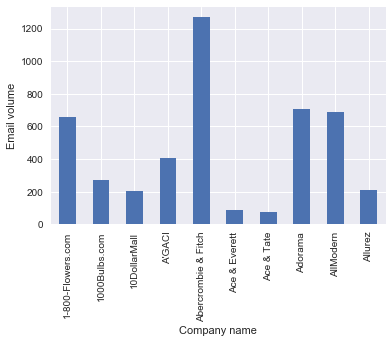

In [94]:
# Visualize  send volume to understand the data a bit better
# Takeaway #1: Email volume varies drastically by company.
# Also, we may have some heavy senders. 1,200+ emails by abercrombie seems extremely high.

email_counts_sum = df.groupby(["company_name"])["prev_email_delta"].count()
bars = email_counts_sum.plot(kind='bar')
bars.set_ylabel("Email volume")
bars.set_xlabel("Company name")

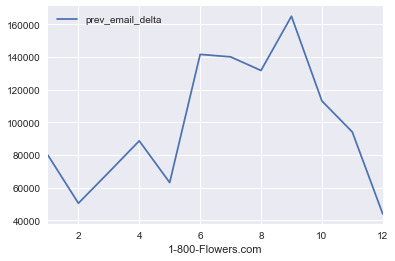

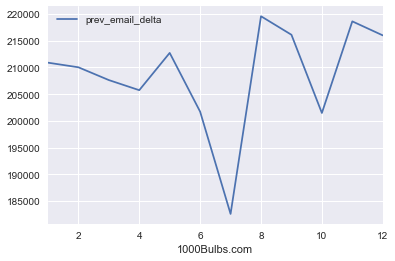

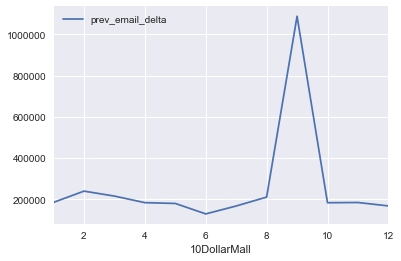

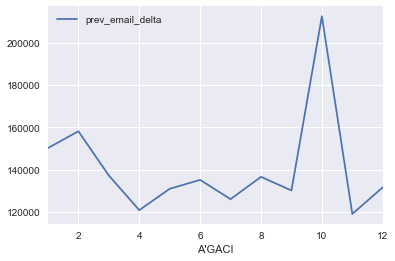

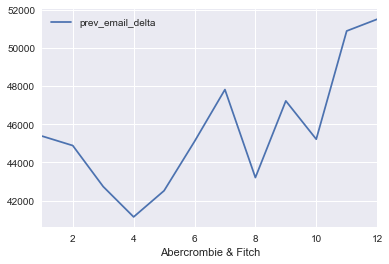

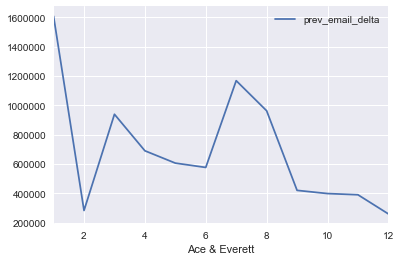

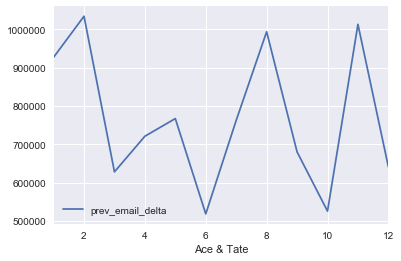

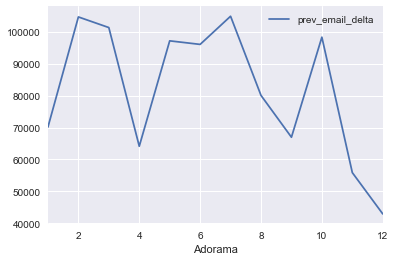

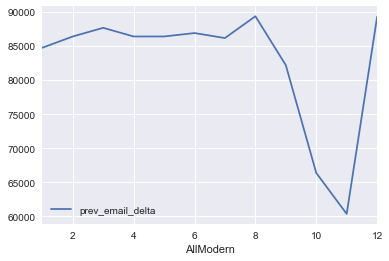

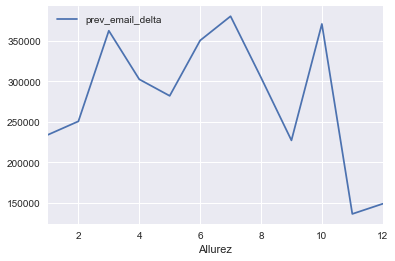

In [95]:
# Let's analyze the sending behavior of these companies
# Takeaway #2: Every company has their own sending behavior!
# Takeaway #3: Seasonality is likely to impact email frequency.
# Note: Spikes == more time in between emails

time_delta_average_by_month = df.groupby(by=['company_name', 'month'])["prev_email_delta"].mean().reset_index()
c_name = time_delta_average_by_month["company_name"].unique()

for i in c_name:
    company = time_delta_average_by_month[time_delta_average_by_month["company_name"] == i].reset_index()
    plot = company.plot(x="month", y="prev_email_delta")
    plot.set_xlabel(i)


In [110]:
# It's not 100% clear here, but it looks like industry could be a helpful feature to include in our model
# Let's visualize this

df.groupby(["industry_name", "company_name"]).prev_email_delta.mean().astype(int).reset_index().sort_values("prev_email_delta")

,industry_name,company_name,prev_email_delta
6,retail,Abercrombie & Fitch,44965
3,photography,Adorama,80291
0,e-commerce,AllModern,82759
4,retail,1-800-Flowers.com,84813
5,retail,A'GACI,134195
1,lighting,1000Bulbs.com,207690
2,other,Ace & Tate,579625


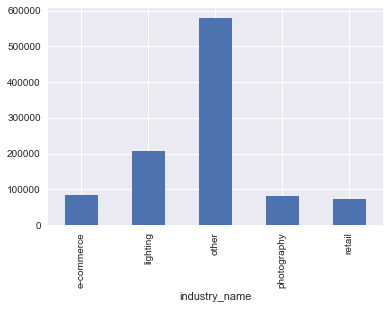

In [111]:
# Visualize the send volume to understand the data a bit better
# Takeaway #4: Consider adding industry as a feature

email_between_time_avg = df.groupby(["industry_name"]).prev_email_delta.mean()
email_between_time_avg.plot(kind='bar')

[]

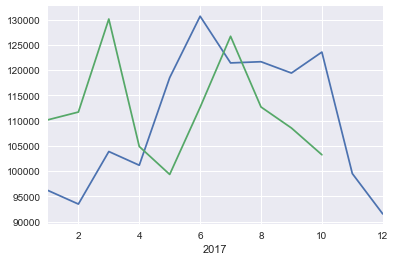

In [131]:
# Let's analyze all of the data by month to see how our 2 years of data compare
# TODO: LABELS NEED FIXING HERE
# TODO: NEED TO ADD TAKEAWAY

fig, axes = plt.subplots()
f1 = df[df.year==2016].groupby("month").prev_email_delta.mean().plot(ax=axes, label="2016")
f2 = df[df.year==2017].groupby("month").prev_email_delta.mean().plot(ax=axes, label="2017")

# Labels are not working =/
f1.set_xlabel("2016")
f2.set_xlabel("2017")
plt.plot()


# Let's analyze the data by month

# plt.figure(figsize=(12,5))
# plt.xlabel('Time between two emails')

# ax1 = df1.time_between_two_emails_in_sec.plot(color='blue',  label='2016')
# ax2 = df2.time_between_two_emails_in_sec.plot(color='red',  label='2017')

# h1, l1 = ax1.get_legend_handles_labels()
# #h2, l2 = ax2.get_legend_handles_labels()


# plt.legend(h1, l1, loc=2)
# plt.show()


# # We can definitely see the impact of seasonality

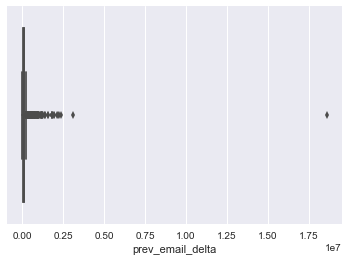

In [98]:
# Next, let's look at the distribution of our email delta

sns.boxplot(x=df["prev_email_delta"])

# Look at that...! We have some outliers. Let's remove them.

(4585, 26)
(4557, 26)
We removed 28 outliers


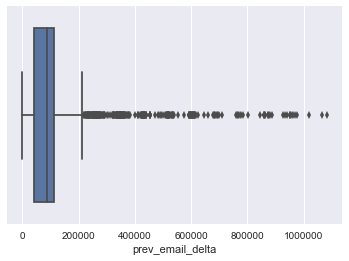

In [99]:
# Remove prev_time_delta outliers

stdev = df.prev_email_delta.std()
mean = df.prev_email_delta.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

non_outliers = df[(df.prev_email_delta >=lower_bound) & (df.prev_email_delta <= upper_bound)]

print(df.shape)
print(non_outliers.shape)
print("We removed", df.shape[0] - non_outliers.shape[0], "outliers")
sns.boxplot(x=non_outliers["prev_email_delta"])

In [100]:
# This looks good, let's assign this back to our df variable

df = non_outliers

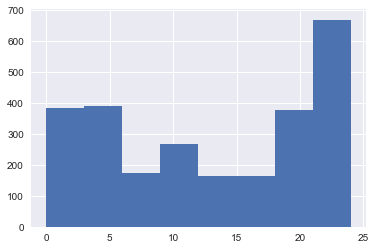

In [105]:
# TODO: Why does this matter

df.hour_delta.hist(bins = [0, 3, 6, 9, 12, 15, 18, 21, 24])

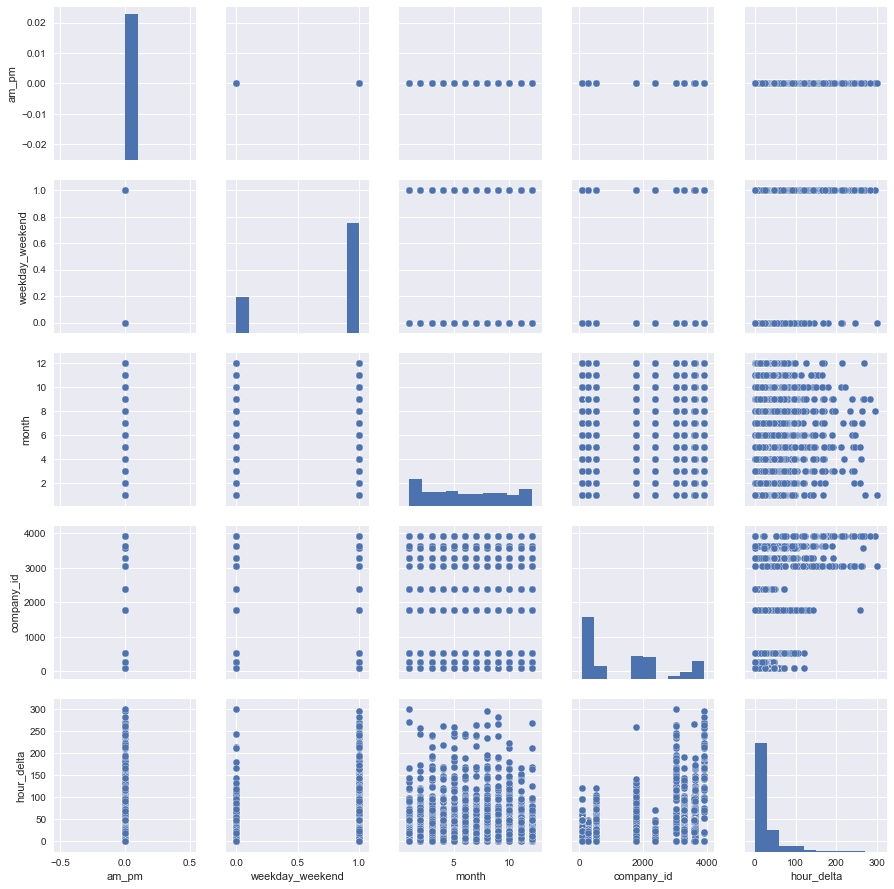

In [104]:
# TODO: Why does this matter

sns.pairplot(df[["am_pm", "weekday_weekend", "month", "company_id", "industry_name", "hour_delta"]])

In [134]:
#heatmap
# f=plt.figure(1,figsize=(15,12))
# for i,weekend in enumerate([0,1]):
#     pvt=pd.pivot_table(data=df[df.weekday_weekend==weekend],values='prev_email_delta',index='day_of_week', columns='company_name')
#     ax=f.add_subplot(2,1,i+1)
#     sns.heatmap(pvt,annot=True)
#     plt.title('Average Time Between Emails'.format(weekend),fontsize=25)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=14)
#     plt.xlabel('company_name',fontsize=18)
#     plt.ylabel('Day of Week',fontsize=18)
#     plt.tight_layout()
# plt.show()

In [135]:
# def season_map(month):
#     season=''
#     if month <=3:
#         season='SPR'
#     elif month<=6:
#         season='SUM'
#     elif month<=9:
#         season='FAL'
#     else: 
#         season='HOL'
#     return season    

In [136]:
# df['season']=df.month.apply(lambda x:season_map(x))

In [137]:
#sns.violinplot(x='season', y='time_between_two_emails_in_sec', data=df, hue='retail_ecommerce' )

## Done with EDA

Features we want:

- Month
- Company
- Industry
- am_pm
- weekend

Models:

- linear regression
- decision tree regressor

Homework:

- [x] Remove outliers
- [x] Clean up code and comment it